# Molecule Alpha Simulations

Repository: https://gitlab.com/linumlabs/molecule-system-modelling

**What do we want to investigate given certain assumptions?**

1. Assuming a buy & hold investment behaviour, what tax rate results in reasonable investor break-even period and reaching the funding goal.
2. Given a certain tax rate, what user base and behaviour is needed to reach funding goal in given period.
3. How can we design the bonding curve such that the funding goal is reached within the given time allocated?
4. How can we design the tax such that investors are rewarded fairly, both early and late?
5. How can we fairly dissolve a project and redistribute its collateral when completed?

**In an ideal efficient market, we hope to:**

1. Reach the funding goal in the given period
2. Reward investors fairly
3. Promote further investment

**Funding outcomes can be any of the following, with certain consequences:**

Market creators
1. Funding reached within time period
2. Funding reached before time period
3. Funding not reached

Investors
1. Investors reach ROI
2. Investors make a profit
3. Investors make a loss

**Given the funding goal and period, what parameters will help us reach that goal?**

1. Tax rate
2. Total investment
3. Investor activity
4. Bonding curve

# Learnings

## Number 1
The variance or sensitivity to a parameter can often tell you a lot more than the raw result of an experiment.
This is especially true in a black-box system or a system where there is large uncertainty surrounding the exogenous inputs or collective behaviour of actors in the system.

# Module imports

In [1]:
import sys
sys.path.append("../lib/python3.7/site-packages")

from cadCAD.configuration.utils import config_sim #env_trigger, var_substep_trigger, config_sim, psub_list
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

# import cadCadFunctions as c2F
from tabulate import tabulate

from matplotlib import cm

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
from scipy.optimize import fsolve
import scipy.integrate as integrate
from datetime import timedelta

from decimal import Decimal
import numpy as np
import pandas as pd
from pynverse import inversefunc

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

from helpers import *

# Experiment Configuration

In [40]:
# Global parameters
#####################################################################
projects = 1
max_investors_per_project = 20

default_gradient = 1/17_500.0
default_shift = 0.5

blocks_per_year = 2102400
blocks_per_month = blocks_per_year/12
blocks_per_day = blocks_per_year/365

# Simulation duration
months = 6
time_steps = int(months*30) # approx. 30 days per month

# Investor user base growth
sigmoid_inflection = time_steps/2
sigmoid_slope = 1/20

# Bonding curves
#####################################################################
def linear(x):
    m = 1/17_500.0
    c = 0.5
    return np.multiply(m, x) + c

def negative_exponential(x):
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x)) + 1

# Investor behaviour
#####################################################################
def hodl_buy(investment, investor_node, bonding_curve): # Buy and hold
    check_funds = investor_node['trading_balance'] >= investment
    check_initial_investment = investor_node['invested'] == 0 #TODO
    return check_funds and check_initial_investment

def roi_buy(investment, investor_node, bonding_curve): # Buy and wait for ROI
    # Calculate estimated value of investor bonded tokens before trades performed
    estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    check_funds = investor_node['trading_balance'] >= investment
    check_initial_investment = investor_node['invested'] == 0 #TODO
    check_roi = estimated_value > 0 and investor_node['invested'] > 0 and (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']/2
    return (check_funds and check_initial_investment)# or (check_funds and check_roi)

def roi_sell(investment, investor_node, bonding_curve): # Buy and wait for ROI
    # Calculate estimated value of investor bonded tokens before trades performed
    estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    check_sentiment = investor_node['sentiment'] < 1
    check_roi = investor_node['cost_of_investment'] > 0 and (estimated_value - investor_node['cost_of_investment']) / investor_node['cost_of_investment'] > investor_node['desired_roi']
    return check_sentiment and check_roi

# cadCAD Parameter Sets
#####################################################################
# Experiment 1:
# e.g. linear curve, hodl, varying tax rate .15 to .35, 1000.0 dollar investment size

params = {
    'sweep': [1, 2],
    'bonding_function': [
        lambda x: linear(x),
#         lambda x: negative_exponential(x)
    ],
    # 
    'investor_buy_behaviour': [
        lambda investment, investor_node, bonding_curve: hodl_buy(investment, investor_node, bonding_curve),
        lambda investment, investor_node, bonding_curve: roi_buy(investment, investor_node, bonding_curve),
    ],
    'investor_sell_behaviour': [
        lambda investment, investor_node, bonding_curve: False,
        lambda investment, investor_node, bonding_curve: roi_sell(investment, investor_node, bonding_curve),
    ],
    'tax_rate': [
        [.15, .35], # increasing over _time_
        [.15, .15]
    ],
    'investment_size': [
        1000.0,
    ]
}

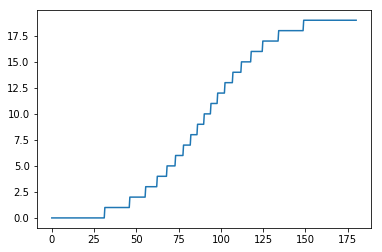

In [3]:
# User base (investor) growth

x = np.linspace(0, time_steps, 500)
y = np.divide(max_investors_per_project, (1 + np.power(np.e, -np.multiply(np.subtract(x, sigmoid_inflection), sigmoid_slope))))
y = np.floor(y)
y[y < 0] = 0

plt.plot(x, y)
plt.show()

# Business Logic

In [4]:
# monotonically increasing polynomial function
def bonding_function(x, m=default_gradient, c=default_shift):
    return params['bonding_function'][0](x)

# note: this tax function is just for the basic plots, and is not used in simulation yet
def tax_function(x, m=default_gradient, c=default_shift):
    return np.multiply(m, x) + c*(1 - params['tax_rate'][0][0])
#     C = 10
#     a = 0.001
#     return C * (1 - np.exp(-a*x))

# this is essentially numerical integration
#     return [np.sum(bonding_function(x[:index])) for index,_ in enumerate(x)]

def integral_function(x):
    return integrate.quad(lambda i: bonding_function(i), 0, x)[0]

# invariant function
def collateral_pool(x):
    return [integral_function(x[index]) for index,_ in enumerate(x)]
    
def inverse_integral_function(x):
    func = inversefunc(integral_function)
    return func(x)

def final_collateral(x):
    return integrate.quad(lambda i: bonding_function(i), x[0], x[-1])

def vault_pool(x):
    return np.subtract(collateral_pool(x), [integrate.quad(lambda i: tax_function(i), x[0], x[index])[0] for index,_ in enumerate(x)])

def investor_pool(x):
    return np.subtract(collateral_pool(x), vault_pool(x))

# Contract functions
#####################################################################
def price_to_mint(x_T, total_supply, pool_balance, gradient):
    return max(integral_function(total_supply + x_T) - pool_balance, 0)

def reward_for_burn(x_T, total_supply, pool_balance):
    return max(pool_balance - integral_function(total_supply - x_T), 0)

def collateral_to_token_buying(x_D, total_supply):
    return inverse_integral_function(integral_function(total_supply) + x_D) - total_supply

def collateral_to_token_selling(x_D, total_supply):
    try:
        return total_supply - inverse_integral_function(integral_function(total_supply) - x_D)
    except ValueError:
        return 0

In [5]:
# Sell token holdings
def sell_holdings(investor_node, bonding_curve, value):
    tokens =  min(collateral_to_token_selling(value, bonding_curve['bonded_tokens']), investor_node['bonded_tokens'])
    value = reward_for_burn(tokens, bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    assert(tokens >= 0)
    assert(value >= 0)
    
    if bonding_curve['bonded_tokens'] >= tokens and bonding_curve['reserve'] >= value:
        bonding_curve['bonded_tokens'] -= tokens
        bonding_curve['reserve'] -= value
    else: return False
        
    investor_node['trading_balance'] += value
    investor_node['invested'] -= value
    investor_node['bonded_tokens'] -= tokens
    
    assert(investor_node['trading_balance'] >= 0)
    #assert(investor_node['invested'] >= 0)
    assert(investor_node['bonded_tokens'] >= 0)
    
    return True

# Basic Economics

In [6]:
x = np.linspace(0,10_000,10_00)

y = bonding_function(x)
t = tax_function(x)
c = collateral_pool(x)
v = vault_pool(x)
i = investor_pool(x)

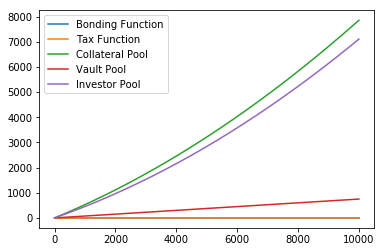

In [7]:
plt.plot(x, y, label='Bonding Function')
plt.plot(x, t, label='Tax Function')
plt.plot(x, c, label='Collateral Pool')
plt.plot(x, v, label='Vault Pool')
plt.plot(x, i, label='Investor Pool')
plt.legend(loc='upper left')
plt.show()

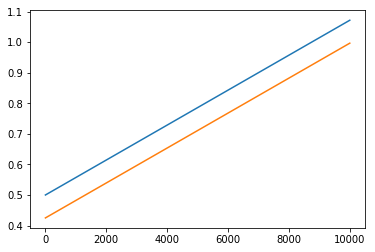

In [8]:
# Bonding function and tax (sell) function
plt.plot(x, y, x, t)
plt.show()

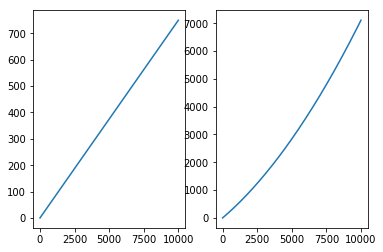

In [9]:
# Vault and investor pool
fig, axs = plt.subplots(1,2)

axs[0].plot(x, v)
axs[1].plot(x, i)

# Network Graph Configuration

### Configure graph

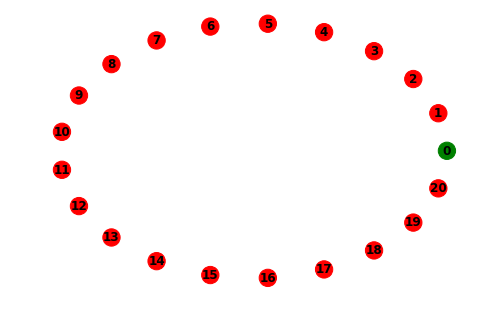

In [11]:
def generate_network(_params=params):
    network = nx.Graph()
    color_map = []

    for index in range(projects):
        color_map.append('green')

        network.add_node(index, _type='project')
        network.nodes[index]['vault'] = {
            'reserve': 0
        }
        network.nodes[index]['bonding_curve'] = {
            'bonded_tokens': 0,
            'reserve': 0
        }
        network.nodes[index]['funding_goal'] = 1_000_000
        network.nodes[index]['funding_period'] = 6
        network.nodes[index]['tax_rate'] = params['tax_rate'][0]

    for index in range(max_investors_per_project):
        color_map.append('red')
        index = index + projects

        network.add_node(index, _type='investor')
        network.nodes[index]['logs'] = {
            'entry': 0,
            'disinvested': False,
            'check_roi': False,
        }
        network.nodes[index]['trading_balance'] = 10_000
        network.nodes[index]['invested'] = 0
        network.nodes[index]['cost_of_investment'] = 0
        network.nodes[index]['bonded_tokens'] = 0
        network.nodes[index]['estimated_value'] = 0
        network.nodes[index]['sentiment'] = 0
        network.nodes[index]['desired_roi'] = .1 # If sentiment < 1, when estimated_value is greater than invested by more than desired ROI, then sell
        network.nodes[index]['taxed'] = 0
    
    return (network, color_map)

network, color_map = generate_network()
nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True) # with_labels=True

def get_networkx_pickle_file(params, state):
    return 'pickle/network_%s_%s.pickle' % (params['sweep'], state['timestep'])

pickle_file = 'pickle/network.pickle'
nx.write_gpickle(network, pickle_file)

class NetworkState(StateType):
    network = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            cls.network: pickle_file,
        }

# cadCAD Model Initialization

In [16]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': 1,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 180),
  'M': {'sweep': 1,
   'bonding_function': <function __main__.<lambda>(x)>,
   'investor_buy_behaviour': <function __main__.<lambda>(investment, investor_node, bonding_curve)>,
   'investor_sell_behaviour': <function __main__.<lambda>(investment, investor_node, bonding_curve)>,
   'tax_rate': [0.15, 0.35],
   'investment_size': 1000.0}},
 {'N': 1,
  'T': range(0, 180),
  'M': {'sweep': 2,
   'bonding_function': <function __main__.<lambda>(x)>,
   'investor_buy_behaviour': <function __main__.<lambda>(investment, investor_node, bonding_curve)>,
   'investor_sell_behaviour': <function __main__.<lambda>(investment, investor_node, bonding_curve)>,
   'tax_rate': [0.15, 0.15],
   'investment_size': 1000.0}}]

In [17]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

initial_state = {
    'network': network
#     **NetworkState.initial_conditions(),
#     **StateExogenous.initial_conditions(),
#     **StateAgregated.initial_conditions()
}

def _new_investors(_params, step, sL, s, _input):        
        network: nx.Graph = s['network']

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')

        currently_invested = list(network.neighbors(project))
        
        number_of_investors = max_investors_per_project/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        number_of_investors = max(math.floor(number_of_investors), 0)

        new_investors = investors[len(currently_invested) : number_of_investors]

        for index in new_investors:
            network.add_edge(project, index)
        
        return ('network', network)

def calculate_tax_rate(_params, s):
    tax_rate_min = _params['tax_rate'][0]
    tax_rate_max = _params['tax_rate'][1]
    tax_rate = min(tax_rate_min + (s['timestep']/time_steps)*(tax_rate_max - tax_rate_min), tax_rate_min)
    return tax_rate
    
def _perform_trades(_params, step, sL, s, _input):
        network: nx.Graph = s['network']
        
        # Extract nodes from network graph
        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
            
            # Calculate buy tax
            collateral_to_invest = _params['investment_size']
            collateral_tax = collateral_to_invest * calculate_tax_rate(_params, s)
            collateral_less_tax = collateral_to_invest - collateral_tax
                  
            if _params['investor_buy_behaviour'](collateral_to_invest, investor_node, bonding_curve):
                investor_node['logs']['disinvested'] = False
                # Calculate token trade value
                tokens_buy = collateral_to_token_buying(collateral_less_tax, bonding_curve['bonded_tokens'])
                
                # Update system balances
                vault['reserve'] += collateral_tax
                bonding_curve['bonded_tokens'] += tokens_buy
                bonding_curve['reserve'] += collateral_less_tax
                
                # Update investor balances
                investor_node['taxed'] += collateral_tax
                investor_node['trading_balance'] -= collateral_to_invest
                investor_node['invested'] += collateral_less_tax
                investor_node['cost_of_investment'] += collateral_to_invest
                investor_node['bonded_tokens'] += tokens_buy
            
            # Check investor status
            estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
            
            # When estimated_value is greater than invested by more than desired ROI, then sell
            if _params['investor_sell_behaviour'](collateral_to_invest, investor_node, bonding_curve):
                # Sell 100% of holdings
                if sell_holdings(investor_node, bonding_curve, estimated_value):
                    investor_node['logs']['disinvested'] = True
            
        return ('network', network)
    
def _update_balances(_params, step, sL, s, _input):
        network: nx.Graph = s['network']

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
            
            # Calculate estimated value of investor bonded tokens after trades performed
            investor_node['estimated_value'] = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
        
        return ('network', network)
    
def genesis(_params, step, sL, s):
    if s['timestep'] == 0 or s['timestep'] == 1:
        return {'genesis': True}
    else:
        return {'genesis': False}

def _create_network(_params, step, sL, s, _input):
    if _input['genesis']:
        network = generate_network(_params)
        pickle_file = get_networkx_pickle_file(_params, s)
        nx.write_gpickle(network, pickle_file)
        return ('network', pickle_file)
    else:
#         network = s['network']
        return ('', '')

partial_state_update_blocks = [
#     {
#         'policies': {
#             'action': genesis,
#         },
#         'variables': {
#             'network': _create_network,
#         }
#     },
    # Exogenous inputs
    {
        'policies': {},
        'variables': {
            'network': _new_investors,
        }
    },
    {
        'policies': {},
        'variables': {
            'network': _perform_trades,
        }
    },
    {
        'policies': {},
        'variables': {
            'network': _update_balances,
        }
    }
]

# Model Simulation

In [18]:
from cadCAD.configuration import append_configs

append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

In [31]:
# sys.setrecursionlimit(5000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)
# raw_result, tensor = run.execute() # The `main()` method returns a tuple; its first elements contains the raw results

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

multi_proc: [<cadCAD.configuration.Configuration object at 0x7f5db0edfcf8>, <cadCAD.configuration.Configuration object at 0x7f5db0edfba8>]
[<cadCAD.configuration.Configuration object at 0x7f5db0edfcf8>, <cadCAD.configuration.Configuration object at 0x7f5db0edfba8>]


# Model Data Analysis

In [21]:
# Choose which experiment parameter configuration to use, integer starting from zero
experiment_config = 1
df = pd.DataFrame(results[experiment_config]['result'])
rdf = df[df.substep==3].copy()

## Plot of bonding curve collateral vs. vault collateral

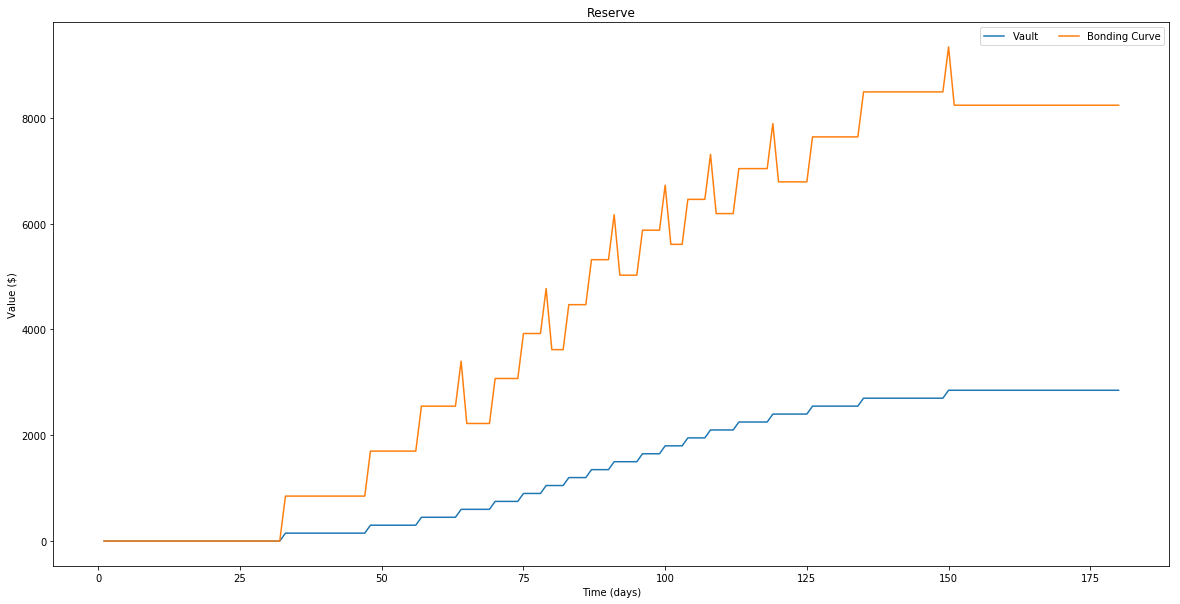

In [22]:
rdf['vault_reserve'] = rdf['network'].apply(lambda g: np.array([g.node[j]['vault']['reserve'] for j in get_node_ids_of_type(g, 'project')]))
rdf['bonding_curve_reserve'] = rdf['network'].apply(lambda g: np.array([g.node[j]['bonding_curve']['reserve'] for j in get_node_ids_of_type(g, 'project')]))

plt.figure(1,figsize=(20,10)) 
plt.plot(rdf.timestep, rdf['vault_reserve'])
plt.plot(rdf.timestep, rdf['bonding_curve_reserve'])
plt.title('Reserve')
plt.ylabel('Value ($)')
plt.xlabel('Time (days)')
plt.legend(['Vault', 'Bonding Curve'], ncol = 2)

In [ ]:
## Plot of investor net asset valuation over time

In [32]:
def investor_nav(g):
    projects = get_node_ids_of_type(g, 'project')
    project = projects[0]
    
    project_node = g.node[project]
    vault = project_node['vault']
    bonding_curve = project_node['bonding_curve']

    result = []
    for j in get_node_ids_of_type(g, 'investor'):
#         (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']
        nav = g.node[j]['estimated_value'] + g.node[j]['trading_balance'] # g.node[j]['estimated_value'] + g.node[j]['trading_balance'] # g.node[j]['logs']['disinvested'] # 
#         print(g.node[j]['logs']['entry'])
        result.append(nav)       
    return result

rdf['investor_nav'] = rdf['network'].apply(lambda g: investor_nav(g))

# node_sizes = np.append([0], np.divide(rdf['investor_balance'][time_steps], 10))
# plt.figure(1,figsize=(12,12)) 
# nx.draw_circular(df[NetworkState.network][time_steps*3], node_color=color_map, node_size=node_sizes, font_weight='bold', with_labels=True) # with_labels=True

# print(type(df[NetworkState.network]))
# df = pd.DataFrame(raw_result)
# print(df[NetworkState.network].apply(lambda g: g.nodes))

Text(0, 0.5, 'valuation ($)')

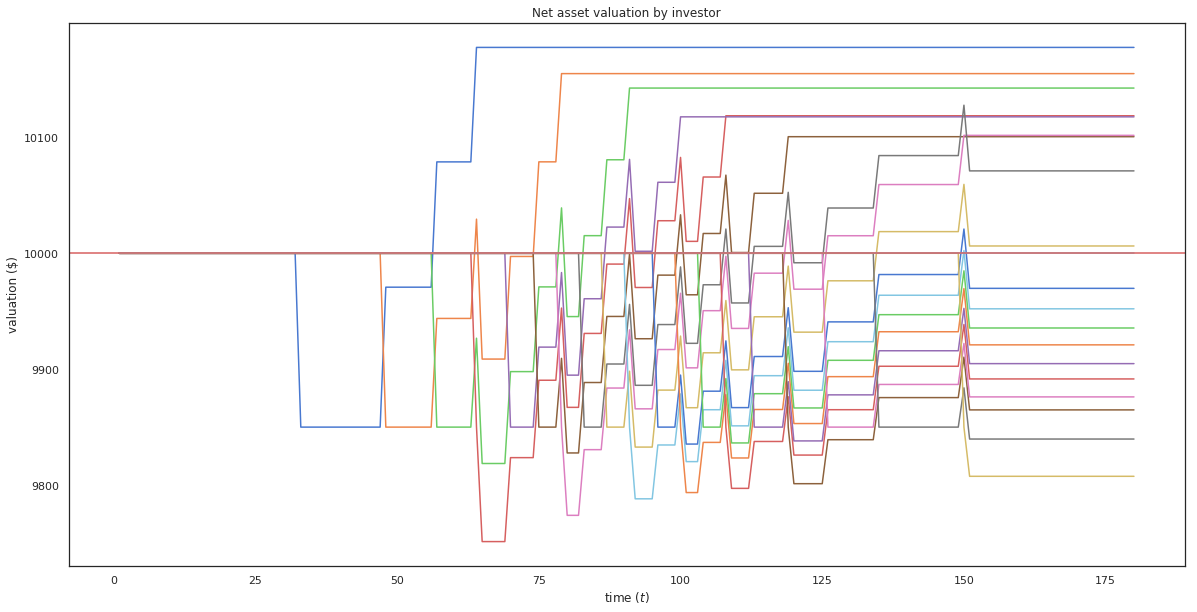

In [34]:
plt.figure(1,figsize=(20,10))
data = make2D('investor_nav', rdf)
plt.plot(rdf.timestep, data)
plt.axhline(y=10_000, color='r', linestyle='-')
plt.title('Net asset valuation by investor')
plt.xlabel('time ($t$)')
plt.ylabel('valuation ($)')

# Collateral Redistribution

## Observations

`spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']`

1. If you redistribute with a flat spot price, no one makes a profit

In [38]:
network = rdf['network'][time_steps*3]
projects = get_node_ids_of_type(network, 'project')
project = projects[0]

project_node = network.node[project]
vault = project_node['vault']
bonding_curve = project_node['bonding_curve']

def redistribution(network):
    if bonding_curve['bonded_tokens'] > 0:
        spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']
    else: spot_price = 0
        
        # (network.node[j]['bonded_tokens']/bonding_curve['bonded_tokens'])*vault['reserve']
    
    result = []
    for j in get_node_ids_of_type(network, 'investor'):
        vault_share = network.node[j]['taxed']
        vault['reserve'] -= vault_share
        print(vault['reserve'])
        print(vault_share)
        if vault['reserve'] < 0:
            print("Oh dear...")
#         vault_share = 0
        balance = (network.node[j]['bonded_tokens']*spot_price + network.node[j]['trading_balance']) - 10_000 # vault_share
        result.append(balance)      
    return result

result = redistribution(network)

print(bonding_curve)
spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']
print('Spot price: %s' % spot_price)
percent_roi = sum(i > 0 for i in result)/len(result)*100
print('Percent ROI: %s' % percent_roi)

-14400.0
150.0
Oh dear...
-14550.0
150.0
Oh dear...
-14700.0
150.0
Oh dear...
-14850.0
150.0
Oh dear...
-15000.0
150.0
Oh dear...
-15150.0
150.0
Oh dear...
-15300.0
150.0
Oh dear...
-15450.0
150.0
Oh dear...
-15600.0
150.0
Oh dear...
-15750.0
150.0
Oh dear...
-15900.0
150.0
Oh dear...
-16050.0
150.0
Oh dear...
-16200.0
150.0
Oh dear...
-16350.0
150.0
Oh dear...
-16500.0
150.0
Oh dear...
-16650.0
150.0
Oh dear...
-16800.0
150.0
Oh dear...
-16950.0
150.0
Oh dear...
-17100.0
150.0
Oh dear...
-17100.0
0
Oh dear...
{'bonded_tokens': 10350.363882535505, 'reserve': 8236.040012721909}
Spot price: 0.7957246823581574
Percent ROI: 35.0


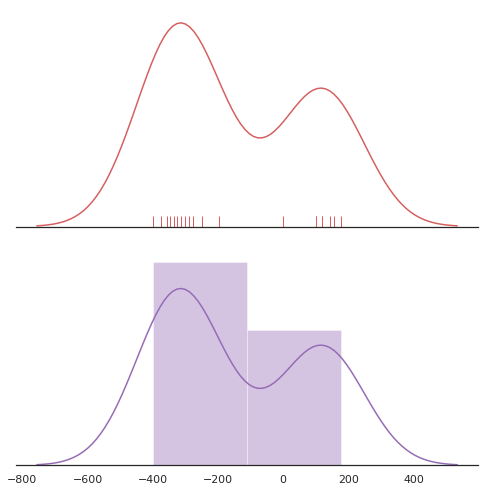

In [39]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate a random univariate dataset
d = result

# Plot a kernel density estimate and rug plot
sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0])

# Plot a historgram and kernel density estimate
sns.distplot(d, color="m", ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

# Continuous Taxation

Tax rate set at a percentage per time period. For example 5% per month. See below re. block time.

* Investigate harburger tax

From the Compound interest rate model:

See https://github.com/compound-finance/compound-money-market/blob/master/contracts/InterestRateModel.sol & https://github.com/compound-finance/compound-money-market

```    /**
      * @notice Gets the current supply interest rate based on the given asset, total cash and total borrows
      * @dev The return value should be scaled by 1e18, thus a return value of
      *      `(true, 1000000000000)` implies an interest rate of 0.000001 or 0.0001% *per block*.
      * @param asset The asset to get the interest rate of
      * @param cash The total cash of the asset in the market
      * @param borrows The total borrows of the asset in the market
      * @return Success or failure and the supply interest rate per block scaled by 10e18
*/
```

They use an interest rate based on `uint constant blocksPerYear = 2102400;`

Probably the best explanation of continuous tokens: https://yos.io/2018/11/10/bonding-curves/

First proposal:

1. Use a continuous token model, with a negative exponential function
2. A negative exponential function should dampen the effect seen in Protea where early investors are unfairly rewarded
3. When it comes time to dissolve the market, the connector weight can be set to 100% - essentially making all tokens the same price, and making the market entirely collateralized
4. A tax can be calculated as a function of block time, collateral pool size, funding goal, and funding period - optimized to reach a funding goal in the given period, no matter what

Assumptions:

1. You want to tax early investors less than late investors - this coincides with having a progressive tax
2. Using a continuous token model you could continuously decollateralize the market more easily

Tax rate should vary between r_min and r_max. An ideal curve for this would be a generalized logistic function with A = -1, let's call it G()
https://en.wikipedia.org/wiki/Generalised_logistic_function

G() where r_min is at the origin and r_max at the assymptote.

When the connector weight is 100%, all investors are taxed equally...? When the connector weight is any less than 100%, early investors are effectively taxed less.
When there is less activity, ideally the tax rate should be lower, to incetivize new investors. If the tax rate is based on the collateral pool size, we need to be careful not to make the funding goal a never reachable assymptote. Given a certain market size, let's calculate the continuous tax rate such that the funding goal is reached in at least the given period.

# Investor Story

At this stage, with a limited understanding of the investment behaviour of our target market, and even the size - we're better off simulting the user base as a monotonically increasing curve that approaches a reasonable assymptote. We can decide what the best and worst case scenarios are and simulate these - this will be what the asymptotic total investment value is, and how long it take to reach it.

We can theorize that given 100 investors, with a fund of 100_000 each to invest, we could end up with a total investment pool of 10_000_000 within an ideal period of 6 months. Worst case we only reach 20% of our invesor market, or 20% of the theoretical total investment pool, and we end up with 2_000_000. We can adjust how we simulate this or what the best and worse case scenarios are, but basically we should create an investor story and work from that, rather than digging into investor behaviour too deeply.